In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.25,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_025_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 831)
(631390, 1)
validation
(74368, 831)
(74368, 1)
test
(85358, 831)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1541121 (5.88 MB)


Trainable params: 1541121 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 10:33 - loss: 0.0840 - STD: 2.9132e-04 - MAE: 0.2791

 13/632 [..............................] - ETA: 2s - loss: 0.0271 - STD: 3.1187e-04 - MAE: 0.1168   

 25/632 [>.............................] - ETA: 2s - loss: 0.0212 - STD: 3.6712e-04 - MAE: 0.1030

 37/632 [>.............................] - ETA: 2s - loss: 0.0187 - STD: 4.7123e-04 - MAE: 0.0926

 50/632 [=>............................] - ETA: 2s - loss: 0.0170 - STD: 6.6495e-04 - MAE: 0.0858

 62/632 [=>............................] - ETA: 2s - loss: 0.0161 - STD: 0.0010 - MAE: 0.0830    

 75/632 [==>...........................] - ETA: 2s - loss: 0.0154 - STD: 0.0020 - MAE: 0.0804

 89/632 [===>..........................] - ETA: 2s - loss: 0.0145 - STD: 0.0050 - MAE: 0.0773

102/632 [===>..........................] - ETA: 2s - loss: 0.0135 - STD: 0.0116 - MAE: 0.0734

108/632 [====>.........................] - ETA: 4s - loss: 0.0130 - STD: 0.0153 - MAE: 0.0716

121/632 [====>.........................] - ETA: 4s - loss: 0.0120 - STD: 0.0233 - MAE: 0.0680

133/632 [=====>........................] - ETA: 3s - loss: 0.0112 - STD: 0.0298 - MAE: 0.0651

146/632 [=====>........................] - ETA: 3s - loss: 0.0105 - STD: 0.0359 - MAE: 0.0624

159/632 [======>.......................] - ETA: 3s - loss: 0.0098 - STD: 0.0409 - MAE: 0.0601

173/632 [=======>......................] - ETA: 3s - loss: 0.0093 - STD: 0.0456 - MAE: 0.0580

185/632 [=======>......................] - ETA: 2s - loss: 0.0088 - STD: 0.0491 - MAE: 0.0564

197/632 [========>.....................] - ETA: 2s - loss: 0.0084 - STD: 0.0522 - MAE: 0.0549

211/632 [=========>....................] - ETA: 2s - loss: 0.0080 - STD: 0.0554 - MAE: 0.0534

228/632 [=========>....................] - ETA: 2s - loss: 0.0076 - STD: 0.0588 - MAE: 0.0517

244/632 [==========>...................] - ETA: 2s - loss: 0.0072 - STD: 0.0616 - MAE: 0.0503

261/632 [===========>..................] - ETA: 2s - loss: 0.0069 - STD: 0.0642 - MAE: 0.0490

277/632 [============>.................] - ETA: 1s - loss: 0.0066 - STD: 0.0665 - MAE: 0.0479

293/632 [============>.................] - ETA: 1s - loss: 0.0063 - STD: 0.0685 - MAE: 0.0469

310/632 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0704 - MAE: 0.0459

326/632 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0720 - MAE: 0.0451

339/632 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0732 - MAE: 0.0445

352/632 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0744 - MAE: 0.0439

366/632 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0756 - MAE: 0.0433

379/632 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0765 - MAE: 0.0428

393/632 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0775 - MAE: 0.0423

407/632 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0784 - MAE: 0.0418

420/632 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0792 - MAE: 0.0414

433/632 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0799 - MAE: 0.0410

446/632 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0406

459/632 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0403

471/632 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0400

485/632 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0396

498/632 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0393

510/632 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0835 - MAE: 0.0390

522/632 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0840 - MAE: 0.0387

535/632 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0385

548/632 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0851 - MAE: 0.0382

560/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0856 - MAE: 0.0380

576/632 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0861 - MAE: 0.0377

592/632 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0866 - MAE: 0.0374

608/632 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0871 - MAE: 0.0372

621/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0875 - MAE: 0.0370

632/632 [==============================] - 4s 5ms/step - loss: 0.0038 - STD: 0.0878 - MAE: 0.0368 - val_loss: 0.0018 - val_STD: 0.0770 - val_MAE: 0.0293


Epoch 2/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0259

 18/632 [..............................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0275 

 35/632 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0273

 52/632 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0275

 68/632 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

 81/632 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

 97/632 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

114/632 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

130/632 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

146/632 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

162/632 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

178/632 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

194/632 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

210/632 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

226/632 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

243/632 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

260/632 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

277/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

294/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

311/632 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

329/632 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

346/632 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

363/632 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

380/632 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

397/632 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

413/632 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

430/632 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

447/632 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

464/632 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

477/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0271

489/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0271

502/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0271

515/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0271

528/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0271

540/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0271

554/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

567/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

580/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

594/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

607/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

620/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

632/632 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

632/632 [==============================] - 2s 4ms/step - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270 - val_loss: 0.0016 - val_STD: 0.0791 - val_MAE: 0.0284


Epoch 3/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0014 - STD: 0.1099 - MAE: 0.0264

 16/632 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0267 

 32/632 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0268

 49/632 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0266

 65/632 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0266

 81/632 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

 97/632 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0265

113/632 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0265

129/632 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0267

146/632 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0267

164/632 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0267

181/632 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

198/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

214/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

230/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

246/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

261/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

277/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

293/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

309/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

324/632 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

341/632 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

359/632 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

377/632 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

394/632 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

411/632 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

427/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

443/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

461/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

478/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

495/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

511/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

527/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

543/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

560/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

576/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

591/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

604/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

620/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

632/632 [==============================] - 2s 4ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265 - val_loss: 0.0014 - val_STD: 0.0788 - val_MAE: 0.0272


Epoch 4/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0236

 16/632 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0265 

 32/632 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0260

 48/632 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

 65/632 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0262

 82/632 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0263

 99/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

115/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

129/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

145/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

160/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

174/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0262

189/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0262

206/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0263

224/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0263

240/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0263

253/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0262

269/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

284/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

300/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

319/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

337/632 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

355/632 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

368/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

382/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

397/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

412/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

429/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

445/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

458/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

471/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

484/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

497/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

510/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

524/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

540/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

555/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

571/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

587/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

605/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

622/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

632/632 [==============================] - 2s 4ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260 - val_loss: 0.0016 - val_STD: 0.0834 - val_MAE: 0.0281


Epoch 5/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0016 - STD: 0.1163 - MAE: 0.0265

 16/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0250 

 32/632 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0257

 48/632 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0260

 64/632 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0259

 81/632 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1074 - MAE: 0.0258

 97/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0257

113/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0257

128/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0257

143/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0257

159/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0256

175/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0256

192/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

210/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

228/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

246/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

264/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

282/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

300/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

318/632 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

335/632 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

353/632 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

370/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

387/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

404/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

422/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

440/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

458/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

476/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

493/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

510/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

527/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

545/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

563/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

580/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

598/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

616/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

632/632 [==============================] - 2s 3ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257 - val_loss: 0.0016 - val_STD: 0.0745 - val_MAE: 0.0293


Epoch 6/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0018 - STD: 0.0985 - MAE: 0.0303

 13/632 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277 

 28/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

 45/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0259

 62/632 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0258

 79/632 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0258

 95/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0256

112/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0255

129/632 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0254

147/632 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0254

165/632 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0253

182/632 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

200/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

218/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

235/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

252/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

269/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

285/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

298/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

314/632 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

332/632 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

349/632 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

367/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

386/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

401/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

414/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

431/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

449/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

467/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

485/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

503/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

521/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

537/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

555/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

573/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

591/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

608/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

626/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

632/632 [==============================] - 2s 3ms/step - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253 - val_loss: 0.0014 - val_STD: 0.0830 - val_MAE: 0.0266


Epoch 7/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0014 - STD: 0.1079 - MAE: 0.0261

 16/632 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1075 - MAE: 0.0266 

 29/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

 43/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

 61/632 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

 79/632 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

 97/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

115/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0258

132/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0256

148/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

164/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

180/632 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

197/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

215/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

232/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

249/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

265/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

281/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

298/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

315/632 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

332/632 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

350/632 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

368/632 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

386/632 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

403/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

421/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

439/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

458/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

476/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

490/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

503/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

516/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

530/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

546/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

561/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

577/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

594/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

611/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

629/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

632/632 [==============================] - 2s 3ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250 - val_loss: 0.0014 - val_STD: 0.0845 - val_MAE: 0.0266


Epoch 8/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0012 - STD: 0.1046 - MAE: 0.0238

 16/632 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0248 

 33/632 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0247

 49/632 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0247

 66/632 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

 82/632 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

 96/632 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

114/632 [====>.........................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

132/632 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

149/632 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

163/632 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

178/632 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0248

191/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0248

205/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0248

218/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

230/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0247

244/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0247

257/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

269/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0246

282/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0246

295/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0246

308/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0246

321/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0246

335/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

348/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

360/632 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0246

373/632 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

385/632 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

398/632 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

412/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

429/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

442/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

455/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

468/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

485/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

503/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

519/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

536/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

554/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

572/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

590/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

608/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

626/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

632/632 [==============================] - 2s 4ms/step - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245 - val_loss: 0.0017 - val_STD: 0.0869 - val_MAE: 0.0280


Epoch 9/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0012 - STD: 0.1091 - MAE: 0.0231

 16/632 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0239 

 32/632 [>.............................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0239

 49/632 [=>............................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0238

 65/632 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0240

 81/632 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0243

 97/632 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0243

113/632 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

130/632 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

146/632 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0243

162/632 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0243

179/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0242

195/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0242

211/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0242

228/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

246/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0242

263/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

279/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

295/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0242

312/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

329/632 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

346/632 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

362/632 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

380/632 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

397/632 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

413/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0241

429/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

446/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

462/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

476/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

489/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

502/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

517/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0241

534/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0241

550/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0241

564/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0241

579/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0241

596/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0240

613/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240

630/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240

632/632 [==============================] - 2s 4ms/step - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240 - val_loss: 0.0016 - val_STD: 0.0877 - val_MAE: 0.0273


Epoch 10/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0011 - STD: 0.1131 - MAE: 0.0233

 17/632 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0236 

 31/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0236

 43/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

 56/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0237

 70/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

 86/632 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0236

 98/632 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

111/632 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0237

126/632 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0238

142/632 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0238

155/632 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

169/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

182/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

195/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

209/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

225/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

242/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

255/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

268/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

280/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

293/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

306/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

318/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

331/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

344/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

360/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0238

372/632 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0237

386/632 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0237

401/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

417/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

433/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

449/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

462/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

474/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0237

486/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0236

499/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0236

513/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0236

527/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

541/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

554/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

569/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

583/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

597/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

614/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

630/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

632/632 [==============================] - 3s 4ms/step - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237 - val_loss: 0.0016 - val_STD: 0.0844 - val_MAE: 0.0273


Epoch 11/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0012 - STD: 0.1023 - MAE: 0.0241

 15/632 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0235 

 28/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0239

 42/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0239

 59/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0237

 73/632 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0236

 85/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1062 - MAE: 0.0235

 97/632 [===>..........................] - ETA: 1s - loss: 0.0011 - STD: 0.1065 - MAE: 0.0234

111/632 [====>.........................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

124/632 [====>.........................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

139/632 [=====>........................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

156/632 [======>.......................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0234

170/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

182/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

195/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0234

210/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

227/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0234

240/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0234

252/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

264/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0234

277/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

290/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

304/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0234

316/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0234

328/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0234

340/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0235

352/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0235

365/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0235

382/632 [=================>............] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0235

399/632 [=================>............] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

415/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

431/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0234

448/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

465/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

482/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

499/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0235

516/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0235

533/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0235

550/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

567/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

584/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

601/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

618/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0234

632/632 [==============================] - 2s 4ms/step - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234 - val_loss: 0.0014 - val_STD: 0.0814 - val_MAE: 0.0260


Epoch 12/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0011 - STD: 0.1096 - MAE: 0.0239

 16/632 [..............................] - ETA: 2s - loss: 0.0011 - STD: 0.1085 - MAE: 0.0228 

 32/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1065 - MAE: 0.0230

 50/632 [=>............................] - ETA: 1s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0231

 68/632 [==>...........................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

 86/632 [===>..........................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0232

104/632 [===>..........................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0232

122/632 [====>.........................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

140/632 [=====>........................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0231

157/632 [======>.......................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0231

173/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0231

190/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

207/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

224/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0230

241/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

258/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

276/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

294/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

312/632 [=============>................] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

329/632 [==============>...............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

346/632 [===============>..............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

363/632 [================>.............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

381/632 [=================>............] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

397/632 [=================>............] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

413/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

430/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

446/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

462/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

478/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

495/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

511/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

528/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

545/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

561/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

575/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

590/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

605/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

619/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

631/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

632/632 [==============================] - 2s 3ms/step - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231 - val_loss: 0.0016 - val_STD: 0.0840 - val_MAE: 0.0275


Epoch 13/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0012 - STD: 0.0985 - MAE: 0.0237

 14/632 [..............................] - ETA: 2s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0232 

 27/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0236

 40/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1062 - MAE: 0.0234

 53/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1064 - MAE: 0.0232

 66/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0232

 79/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0231

 92/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0232

104/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0232

118/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1065 - MAE: 0.0231

135/632 [=====>........................] - ETA: 1s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0230

152/632 [======>.......................] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0230

169/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

183/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

198/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

212/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0231

227/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0230

245/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0230

261/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0230

279/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0230

295/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0230

308/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0230

324/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0231

341/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0231

359/632 [================>.............] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0230

374/632 [================>.............] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0230

389/632 [=================>............] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0230

406/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0230

423/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0230

436/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0230

452/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0230

465/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0230

478/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

492/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

505/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0230

518/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

531/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

544/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

556/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

571/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

586/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0230

600/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0230

617/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0230

632/632 [==============================] - 2s 4ms/step - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230 - val_loss: 0.0019 - val_STD: 0.0879 - val_MAE: 0.0288


Epoch 14/10000


  1/632 [..............................] - ETA: 15s - loss: 8.8852e-04 - STD: 0.1101 - MAE: 0.0212

 14/632 [..............................] - ETA: 2s - loss: 9.8735e-04 - STD: 0.1101 - MAE: 0.0221 

 26/632 [>.............................] - ETA: 2s - loss: 9.9645e-04 - STD: 0.1093 - MAE: 0.0222

 39/632 [>.............................] - ETA: 2s - loss: 9.9890e-04 - STD: 0.1082 - MAE: 0.0222

 53/632 [=>............................] - ETA: 2s - loss: 0.0010 - STD: 0.1084 - MAE: 0.0223    

 66/632 [==>...........................] - ETA: 2s - loss: 0.0010 - STD: 0.1084 - MAE: 0.0223

 83/632 [==>...........................] - ETA: 2s - loss: 0.0010 - STD: 0.1081 - MAE: 0.0223

 99/632 [===>..........................] - ETA: 1s - loss: 0.0010 - STD: 0.1081 - MAE: 0.0225

117/632 [====>.........................] - ETA: 1s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

135/632 [=====>........................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0227

153/632 [======>.......................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0228

170/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0228

183/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

198/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

215/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0227

231/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0227

245/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

262/632 [===========>..................] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

279/632 [============>.................] - ETA: 1s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

296/632 [=============>................] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

313/632 [=============>................] - ETA: 1s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

330/632 [==============>...............] - ETA: 1s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

348/632 [===============>..............] - ETA: 0s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

367/632 [================>.............] - ETA: 0s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

386/632 [=================>............] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

404/632 [==================>...........] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

422/632 [===================>..........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

440/632 [===================>..........] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

458/632 [====================>.........] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

476/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

494/632 [======================>.......] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

511/632 [=======================>......] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

527/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

543/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

559/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

577/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

595/632 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

613/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

631/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

632/632 [==============================] - 2s 3ms/step - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225 - val_loss: 0.0017 - val_STD: 0.0858 - val_MAE: 0.0274


Epoch 15/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0222

 14/632 [..............................] - ETA: 2s - loss: 0.0010 - STD: 0.1085 - MAE: 0.0225 

 29/632 [>.............................] - ETA: 2s - loss: 0.0010 - STD: 0.1088 - MAE: 0.0224

 45/632 [=>............................] - ETA: 2s - loss: 0.0010 - STD: 0.1083 - MAE: 0.0224

 61/632 [=>............................] - ETA: 1s - loss: 0.0010 - STD: 0.1082 - MAE: 0.0226

 77/632 [==>...........................] - ETA: 1s - loss: 0.0010 - STD: 0.1082 - MAE: 0.0225

 95/632 [===>..........................] - ETA: 1s - loss: 0.0010 - STD: 0.1081 - MAE: 0.0224

113/632 [====>.........................] - ETA: 1s - loss: 0.0010 - STD: 0.1084 - MAE: 0.0225

131/632 [=====>........................] - ETA: 1s - loss: 0.0010 - STD: 0.1083 - MAE: 0.0225

148/632 [======>.......................] - ETA: 1s - loss: 0.0010 - STD: 0.1082 - MAE: 0.0224

164/632 [======>.......................] - ETA: 1s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0225

180/632 [=======>......................] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0225

197/632 [========>.....................] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0225

213/632 [=========>....................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0225

228/632 [=========>....................] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0225

245/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0225

262/632 [===========>..................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

279/632 [============>.................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

295/632 [=============>................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

311/632 [=============>................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

328/632 [==============>...............] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

344/632 [===============>..............] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

360/632 [================>.............] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

377/632 [================>.............] - ETA: 0s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0224

394/632 [=================>............] - ETA: 0s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0224

411/632 [==================>...........] - ETA: 0s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0224

427/632 [===================>..........] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

444/632 [====================>.........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

460/632 [====================>.........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

476/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

492/632 [======================>.......] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

508/632 [=======================>......] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

524/632 [=======================>......] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

540/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0225

556/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

573/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

590/632 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

607/632 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

622/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

632/632 [==============================] - 2s 3ms/step - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224 - val_loss: 0.0016 - val_STD: 0.0840 - val_MAE: 0.0270


Epoch 16/10000


  1/632 [..............................] - ETA: 11s - loss: 9.1405e-04 - STD: 0.1059 - MAE: 0.0211

 14/632 [..............................] - ETA: 2s - loss: 9.4379e-04 - STD: 0.1078 - MAE: 0.0217 

 27/632 [>.............................] - ETA: 2s - loss: 9.7516e-04 - STD: 0.1092 - MAE: 0.0219

 42/632 [>.............................] - ETA: 2s - loss: 9.7869e-04 - STD: 0.1084 - MAE: 0.0220

 58/632 [=>............................] - ETA: 2s - loss: 9.9367e-04 - STD: 0.1079 - MAE: 0.0222

 75/632 [==>...........................] - ETA: 1s - loss: 9.9922e-04 - STD: 0.1077 - MAE: 0.0222

 92/632 [===>..........................] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0224    

109/632 [====>.........................] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0226

126/632 [====>.........................] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0225

143/632 [=====>........................] - ETA: 1s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0225

160/632 [======>.......................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

177/632 [=======>......................] - ETA: 1s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0224

194/632 [========>.....................] - ETA: 1s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0224

211/632 [=========>....................] - ETA: 1s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0224

228/632 [=========>....................] - ETA: 1s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0223

246/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1081 - MAE: 0.0223

263/632 [===========>..................] - ETA: 1s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0223

279/632 [============>.................] - ETA: 1s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0223

296/632 [=============>................] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0223

312/632 [=============>................] - ETA: 1s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0223

329/632 [==============>...............] - ETA: 0s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0223

347/632 [===============>..............] - ETA: 0s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0223

363/632 [================>.............] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0222

379/632 [================>.............] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0222

395/632 [=================>............] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0222

411/632 [==================>...........] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0222

428/632 [===================>..........] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0222

446/632 [====================>.........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0222

463/632 [====================>.........] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0222

479/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0222

496/632 [======================>.......] - ETA: 0s - loss: 9.9993e-04 - STD: 0.1077 - MAE: 0.0222

513/632 [=======================>......] - ETA: 0s - loss: 9.9844e-04 - STD: 0.1078 - MAE: 0.0222

530/632 [========================>.....] - ETA: 0s - loss: 9.9756e-04 - STD: 0.1078 - MAE: 0.0222

545/632 [========================>.....] - ETA: 0s - loss: 9.9523e-04 - STD: 0.1078 - MAE: 0.0222

561/632 [=========================>....] - ETA: 0s - loss: 9.9479e-04 - STD: 0.1079 - MAE: 0.0222

577/632 [==========================>...] - ETA: 0s - loss: 9.9319e-04 - STD: 0.1079 - MAE: 0.0221

592/632 [===========================>..] - ETA: 0s - loss: 9.9291e-04 - STD: 0.1079 - MAE: 0.0221

608/632 [===========================>..] - ETA: 0s - loss: 9.9317e-04 - STD: 0.1079 - MAE: 0.0221

624/632 [============================>.] - ETA: 0s - loss: 9.9354e-04 - STD: 0.1079 - MAE: 0.0222

632/632 [==============================] - 2s 4ms/step - loss: 9.9415e-04 - STD: 0.1079 - MAE: 0.0222 - val_loss: 0.0015 - val_STD: 0.0830 - val_MAE: 0.0269


Epoch 17/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0012 - STD: 0.0976 - MAE: 0.0240

 14/632 [..............................] - ETA: 2s - loss: 9.8443e-04 - STD: 0.1086 - MAE: 0.0222

 26/632 [>.............................] - ETA: 2s - loss: 9.6407e-04 - STD: 0.1069 - MAE: 0.0219

 39/632 [>.............................] - ETA: 2s - loss: 9.7204e-04 - STD: 0.1072 - MAE: 0.0219

 52/632 [=>............................] - ETA: 2s - loss: 9.9551e-04 - STD: 0.1079 - MAE: 0.0222

 64/632 [==>...........................] - ETA: 2s - loss: 0.0010 - STD: 0.1073 - MAE: 0.0223    

 77/632 [==>...........................] - ETA: 2s - loss: 9.9942e-04 - STD: 0.1077 - MAE: 0.0223

 91/632 [===>..........................] - ETA: 2s - loss: 9.9984e-04 - STD: 0.1075 - MAE: 0.0222

104/632 [===>..........................] - ETA: 2s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0223    

117/632 [====>.........................] - ETA: 2s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0223

130/632 [=====>........................] - ETA: 2s - loss: 9.9798e-04 - STD: 0.1075 - MAE: 0.0222

144/632 [=====>........................] - ETA: 1s - loss: 9.9389e-04 - STD: 0.1074 - MAE: 0.0222

161/632 [======>.......................] - ETA: 1s - loss: 9.8867e-04 - STD: 0.1074 - MAE: 0.0221

177/632 [=======>......................] - ETA: 1s - loss: 9.9007e-04 - STD: 0.1076 - MAE: 0.0222

190/632 [========>.....................] - ETA: 1s - loss: 9.9063e-04 - STD: 0.1076 - MAE: 0.0222

202/632 [========>.....................] - ETA: 1s - loss: 9.8873e-04 - STD: 0.1077 - MAE: 0.0221

215/632 [=========>....................] - ETA: 1s - loss: 9.8783e-04 - STD: 0.1078 - MAE: 0.0221

231/632 [=========>....................] - ETA: 1s - loss: 9.8663e-04 - STD: 0.1078 - MAE: 0.0221

245/632 [==========>...................] - ETA: 1s - loss: 9.9163e-04 - STD: 0.1079 - MAE: 0.0222

257/632 [===========>..................] - ETA: 1s - loss: 9.8936e-04 - STD: 0.1079 - MAE: 0.0221

269/632 [===========>..................] - ETA: 1s - loss: 9.9100e-04 - STD: 0.1079 - MAE: 0.0222

283/632 [============>.................] - ETA: 1s - loss: 9.8928e-04 - STD: 0.1079 - MAE: 0.0221

297/632 [=============>................] - ETA: 1s - loss: 9.8591e-04 - STD: 0.1079 - MAE: 0.0221

310/632 [=============>................] - ETA: 1s - loss: 9.8685e-04 - STD: 0.1080 - MAE: 0.0221

323/632 [==============>...............] - ETA: 1s - loss: 9.8461e-04 - STD: 0.1079 - MAE: 0.0221

335/632 [==============>...............] - ETA: 1s - loss: 9.8249e-04 - STD: 0.1078 - MAE: 0.0221

348/632 [===============>..............] - ETA: 1s - loss: 9.8259e-04 - STD: 0.1078 - MAE: 0.0221

362/632 [================>.............] - ETA: 1s - loss: 9.8111e-04 - STD: 0.1078 - MAE: 0.0221

376/632 [================>.............] - ETA: 0s - loss: 9.7999e-04 - STD: 0.1078 - MAE: 0.0220

391/632 [=================>............] - ETA: 0s - loss: 9.7889e-04 - STD: 0.1078 - MAE: 0.0220

404/632 [==================>...........] - ETA: 0s - loss: 9.7961e-04 - STD: 0.1077 - MAE: 0.0220

417/632 [==================>...........] - ETA: 0s - loss: 9.8118e-04 - STD: 0.1077 - MAE: 0.0220

429/632 [===================>..........] - ETA: 0s - loss: 9.8064e-04 - STD: 0.1078 - MAE: 0.0220

441/632 [===================>..........] - ETA: 0s - loss: 9.7991e-04 - STD: 0.1078 - MAE: 0.0220

453/632 [====================>.........] - ETA: 0s - loss: 9.7860e-04 - STD: 0.1078 - MAE: 0.0220

467/632 [=====================>........] - ETA: 0s - loss: 9.7753e-04 - STD: 0.1078 - MAE: 0.0220

480/632 [=====================>........] - ETA: 0s - loss: 9.7697e-04 - STD: 0.1078 - MAE: 0.0220

493/632 [======================>.......] - ETA: 0s - loss: 9.7665e-04 - STD: 0.1078 - MAE: 0.0220

509/632 [=======================>......] - ETA: 0s - loss: 9.7787e-04 - STD: 0.1078 - MAE: 0.0220

525/632 [=======================>......] - ETA: 0s - loss: 9.7701e-04 - STD: 0.1078 - MAE: 0.0220

541/632 [========================>.....] - ETA: 0s - loss: 9.7634e-04 - STD: 0.1079 - MAE: 0.0220

557/632 [=========================>....] - ETA: 0s - loss: 9.7641e-04 - STD: 0.1079 - MAE: 0.0220

573/632 [==========================>...] - ETA: 0s - loss: 9.7711e-04 - STD: 0.1079 - MAE: 0.0220

588/632 [==========================>...] - ETA: 0s - loss: 9.7663e-04 - STD: 0.1079 - MAE: 0.0220

604/632 [===========================>..] - ETA: 0s - loss: 9.7620e-04 - STD: 0.1079 - MAE: 0.0220

619/632 [============================>.] - ETA: 0s - loss: 9.7560e-04 - STD: 0.1079 - MAE: 0.0220

632/632 [==============================] - 3s 4ms/step - loss: 9.7570e-04 - STD: 0.1080 - MAE: 0.0220 - val_loss: 0.0015 - val_STD: 0.0820 - val_MAE: 0.0262


Epoch 18/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0011 - STD: 0.0976 - MAE: 0.0226

 13/632 [..............................] - ETA: 2s - loss: 9.8274e-04 - STD: 0.1090 - MAE: 0.0222

 26/632 [>.............................] - ETA: 2s - loss: 9.7693e-04 - STD: 0.1086 - MAE: 0.0222

 39/632 [>.............................] - ETA: 2s - loss: 9.7039e-04 - STD: 0.1088 - MAE: 0.0220

 52/632 [=>............................] - ETA: 2s - loss: 9.5978e-04 - STD: 0.1090 - MAE: 0.0219

 64/632 [==>...........................] - ETA: 2s - loss: 9.5258e-04 - STD: 0.1087 - MAE: 0.0218

 79/632 [==>...........................] - ETA: 2s - loss: 9.5250e-04 - STD: 0.1084 - MAE: 0.0218

 95/632 [===>..........................] - ETA: 2s - loss: 9.4504e-04 - STD: 0.1083 - MAE: 0.0217

111/632 [====>.........................] - ETA: 1s - loss: 9.3837e-04 - STD: 0.1083 - MAE: 0.0216

127/632 [=====>........................] - ETA: 1s - loss: 9.4170e-04 - STD: 0.1083 - MAE: 0.0217

140/632 [=====>........................] - ETA: 1s - loss: 9.4471e-04 - STD: 0.1083 - MAE: 0.0217

156/632 [======>.......................] - ETA: 1s - loss: 9.4714e-04 - STD: 0.1082 - MAE: 0.0217

170/632 [=======>......................] - ETA: 1s - loss: 9.5122e-04 - STD: 0.1083 - MAE: 0.0218

186/632 [=======>......................] - ETA: 1s - loss: 9.5100e-04 - STD: 0.1083 - MAE: 0.0218

201/632 [========>.....................] - ETA: 1s - loss: 9.4868e-04 - STD: 0.1084 - MAE: 0.0218

216/632 [=========>....................] - ETA: 1s - loss: 9.5365e-04 - STD: 0.1084 - MAE: 0.0218

228/632 [=========>....................] - ETA: 1s - loss: 9.5356e-04 - STD: 0.1083 - MAE: 0.0218

241/632 [==========>...................] - ETA: 1s - loss: 9.5212e-04 - STD: 0.1083 - MAE: 0.0218

258/632 [===========>..................] - ETA: 1s - loss: 9.4965e-04 - STD: 0.1082 - MAE: 0.0218

274/632 [============>.................] - ETA: 1s - loss: 9.4854e-04 - STD: 0.1083 - MAE: 0.0217

289/632 [============>.................] - ETA: 1s - loss: 9.4815e-04 - STD: 0.1083 - MAE: 0.0217

306/632 [=============>................] - ETA: 1s - loss: 9.4821e-04 - STD: 0.1083 - MAE: 0.0218

322/632 [==============>...............] - ETA: 1s - loss: 9.4883e-04 - STD: 0.1082 - MAE: 0.0218

338/632 [===============>..............] - ETA: 1s - loss: 9.5173e-04 - STD: 0.1082 - MAE: 0.0218

350/632 [===============>..............] - ETA: 1s - loss: 9.5137e-04 - STD: 0.1083 - MAE: 0.0218

362/632 [================>.............] - ETA: 0s - loss: 9.5071e-04 - STD: 0.1083 - MAE: 0.0218

375/632 [================>.............] - ETA: 0s - loss: 9.4967e-04 - STD: 0.1082 - MAE: 0.0218

389/632 [=================>............] - ETA: 0s - loss: 9.4945e-04 - STD: 0.1083 - MAE: 0.0218

402/632 [==================>...........] - ETA: 0s - loss: 9.4758e-04 - STD: 0.1082 - MAE: 0.0217

417/632 [==================>...........] - ETA: 0s - loss: 9.5033e-04 - STD: 0.1081 - MAE: 0.0218

433/632 [===================>..........] - ETA: 0s - loss: 9.5158e-04 - STD: 0.1081 - MAE: 0.0218

449/632 [====================>.........] - ETA: 0s - loss: 9.5435e-04 - STD: 0.1080 - MAE: 0.0218

463/632 [====================>.........] - ETA: 0s - loss: 9.5453e-04 - STD: 0.1080 - MAE: 0.0218

476/632 [=====================>........] - ETA: 0s - loss: 9.5328e-04 - STD: 0.1081 - MAE: 0.0218

489/632 [======================>.......] - ETA: 0s - loss: 9.5280e-04 - STD: 0.1081 - MAE: 0.0218

500/632 [======================>.......] - ETA: 0s - loss: 9.5199e-04 - STD: 0.1081 - MAE: 0.0218

513/632 [=======================>......] - ETA: 0s - loss: 9.5155e-04 - STD: 0.1081 - MAE: 0.0218

525/632 [=======================>......] - ETA: 0s - loss: 9.5063e-04 - STD: 0.1081 - MAE: 0.0218

539/632 [========================>.....] - ETA: 0s - loss: 9.5200e-04 - STD: 0.1080 - MAE: 0.0218

553/632 [=========================>....] - ETA: 0s - loss: 9.5319e-04 - STD: 0.1080 - MAE: 0.0218

567/632 [=========================>....] - ETA: 0s - loss: 9.5244e-04 - STD: 0.1080 - MAE: 0.0218

579/632 [==========================>...] - ETA: 0s - loss: 9.5175e-04 - STD: 0.1081 - MAE: 0.0218

591/632 [===========================>..] - ETA: 0s - loss: 9.5289e-04 - STD: 0.1081 - MAE: 0.0218

603/632 [===========================>..] - ETA: 0s - loss: 9.5221e-04 - STD: 0.1081 - MAE: 0.0218

615/632 [============================>.] - ETA: 0s - loss: 9.5156e-04 - STD: 0.1081 - MAE: 0.0218

628/632 [============================>.] - ETA: 0s - loss: 9.5063e-04 - STD: 0.1081 - MAE: 0.0218

632/632 [==============================] - 3s 4ms/step - loss: 9.5072e-04 - STD: 0.1080 - MAE: 0.0218 - val_loss: 0.0022 - val_STD: 0.0896 - val_MAE: 0.0305


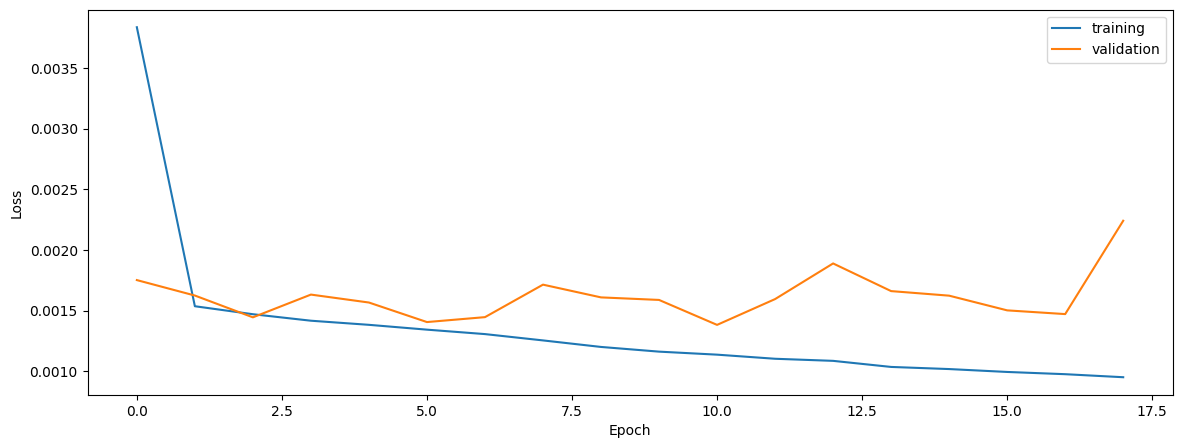

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.956703653646919
0.9583645491261958
0.9466773654146843


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.956703653646919
0.9583645491261958
0.9466773654146843


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9614835253211595
0.9606192103865888
0.9579603820482692


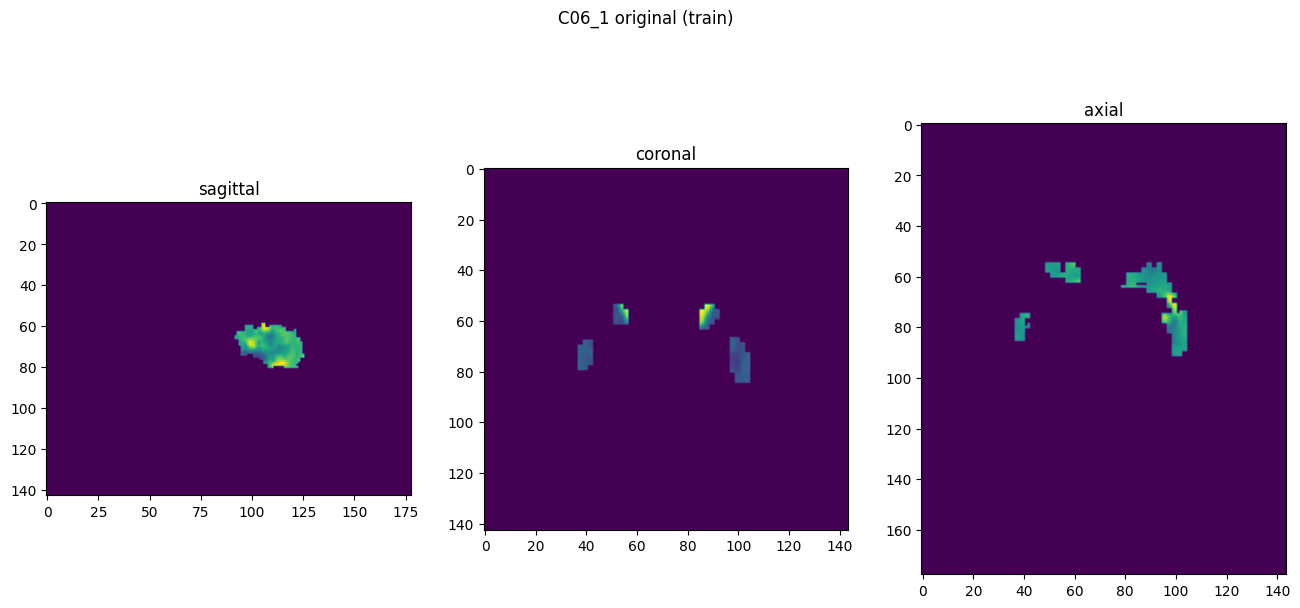

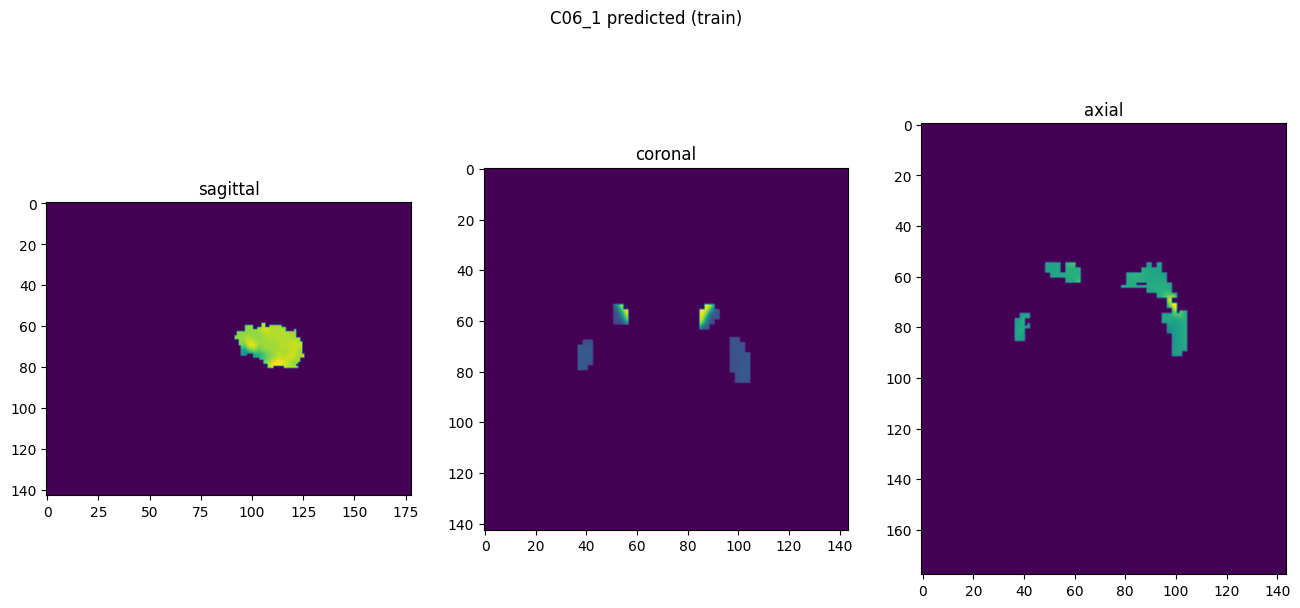

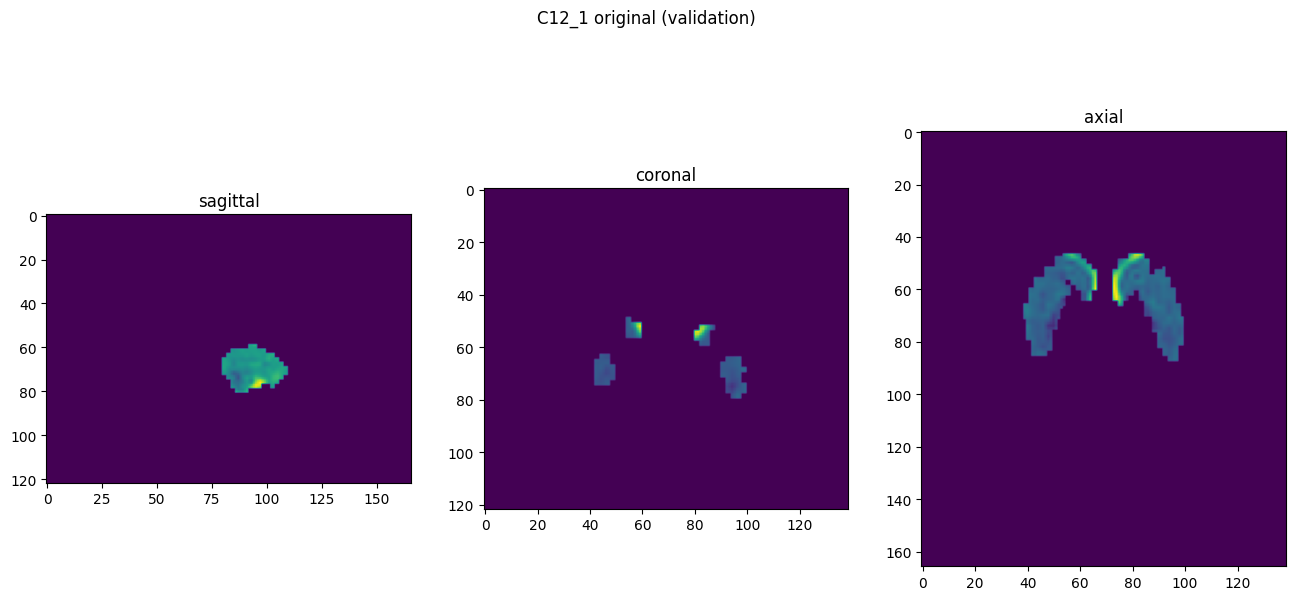

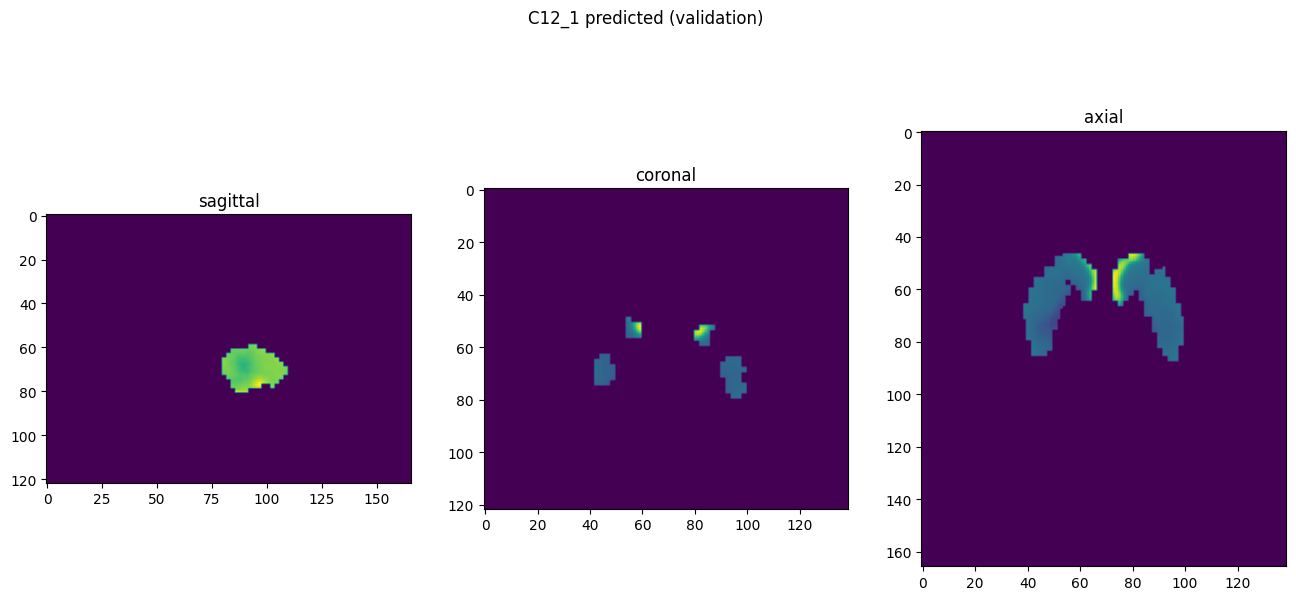

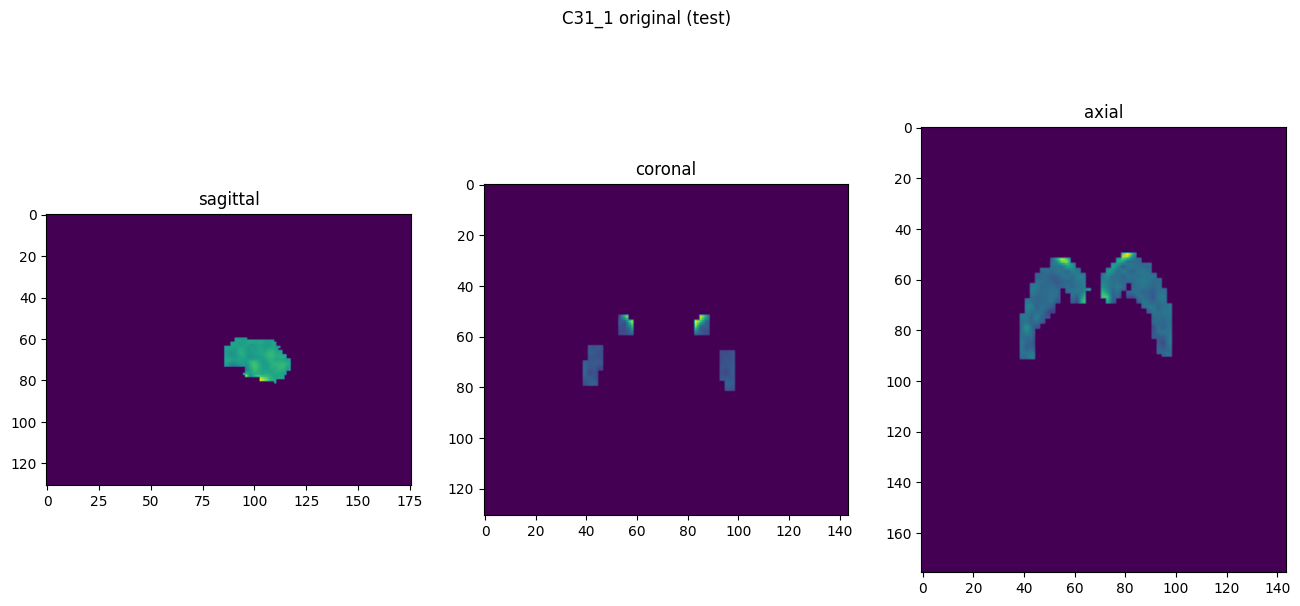

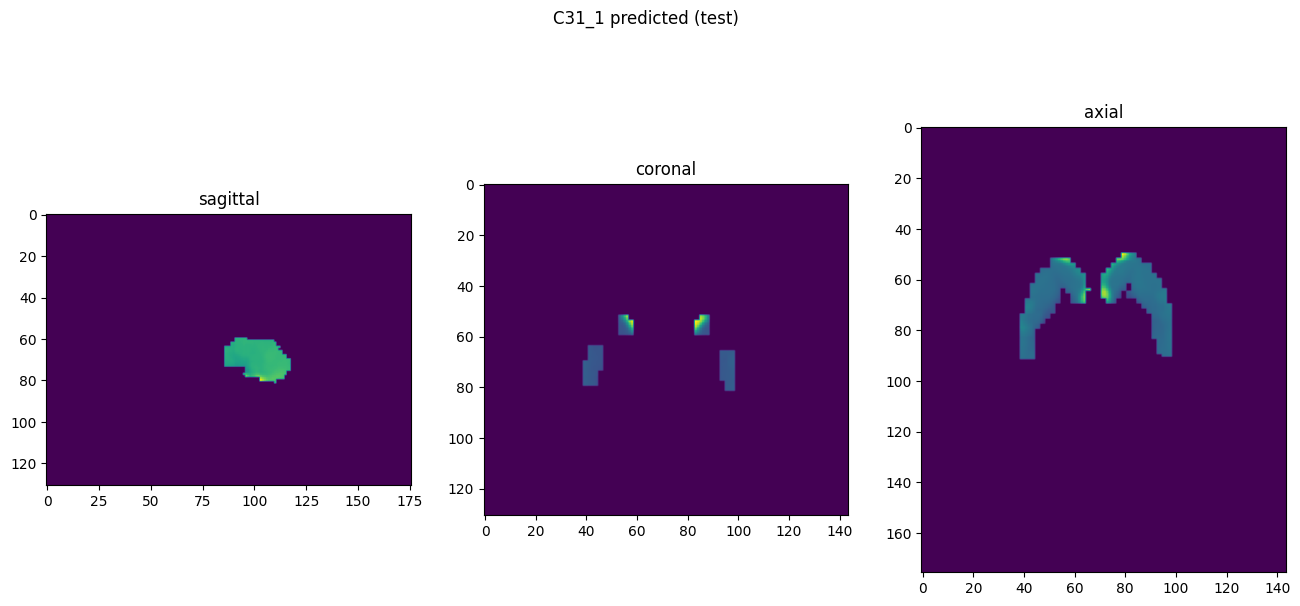

In [10]:
showResults(model, gen, threshold=None, background=False)